In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_context('talk')

In [3]:
usage = pd.read_table("uppmax_data/20151217.tsv", index_col=0, names=["cluster", "jobstate", "user", 
                                                                      "project", "job_name", "endtime", 
                                                                      "runtime", "flags", "booked", 
                                                                      "cores", "node", "jobstats"])

In [4]:
def runtime_to_minutes(runtime_s):
    if '-' in runtime_s:
        try:
            days_s, hours_s = runtime_s.split('-')
            days = int(days_s)
        except ValueError:
            print runtime_s
            raise
    else:
        days = 0
        hours_s = runtime_s
    hours, minutes, seconds = (int(x) for x in hours_s.split(':'))
    return (days*24+hours)*60 + minutes

In [5]:
usage['runtime_minutes'] = usage.runtime.apply(runtime_to_minutes)
usage['cpu_minutes'] = usage['runtime_minutes'] * usage['booked']

In [6]:
minutes_stats = {}
minutes_stats['no_flags'] = usage[usage['flags'] =='.'].cpu_minutes.sum()
minutes_stats['fat_node_flag_only'] = usage[usage['flags'] == 'node_type_overbooked:mem512GB:mem256GB'].cpu_minutes.sum() + \
    usage[usage['flags'] == 'node_type_overbooked:mem512GB:mem128GB'].cpu_minutes.sum() + \
    usage[usage['flags'] == 'node_type_overbooked:mem256GB:mem128GB'].cpu_minutes.sum()
minutes_stats['other_overbooked'] = usage[usage['flags'] !='.'].cpu_minutes.sum() - minutes_stats['fat_node_flag_only']

## Proportion of efficiently running jobs
Jobs that are flagged with using a fat node, when a thin node would have worked are not considered wasteful since there is normally no less access to fat nodes than thin nodes.

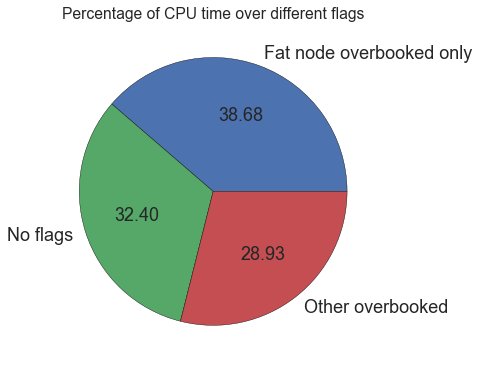

In [7]:
ax = pd.Series(minutes_stats).plot(kind='pie', figsize=(6,6), autopct='%.2f', fontsize=18, labels=["Fat node overbooked only", "No flags", "Other overbooked"])
t = ax.set_title("Percentage of CPU time over different flags")

In [8]:
usage_other_overbooked = usage[(usage['flags'] != '.') & ~(usage['flags'].isin(['node_type_overbooked:mem512GB:mem256GB',
                                                                                'node_type_overbooked:mem512GB:mem128GB',
                                                                                'node_type_overbooked:mem256GB:mem128GB',
                                                                                '!!swap_used']))]

## Finding the worst offending jobs
Jobs which were overbooked that used the most cpu time

In [9]:
usage_other_overbooked.sort('cpu_minutes', ascending=False).head(10)[['flags','user','job_name', 'cpu_minutes']]

,flags,user,job_name,cpu_minutes
6483189,"overbooked:44%,!!half_overbooked,node_type_ove...",john,bt2-build.GOS.0001109.SwedAmLakes.asm.fasta,28144
6561380,"overbooked:44%,!!half_overbooked,node_type_ove...",john,bt2-build.GOS.0001109.SwedAmLakes.asm.fasta,24112
6474967,"overbooked:44%,!!half_overbooked,node_type_ove...",john,bt2-build.GOS.0001109.SwedAmLakes.asm.fasta,23040
6575236,"overbooked:33%,!!half_overbooked,cores_overboo...",luisah,_interactive,8280
6625019,"overbooked:38%,!!half_overbooked,node_type_ove...",luisah,dadamain,7184
6515502,"overbooked:59%,!!swap_used,cores_overbooked:16:4",alneberg,snakemake_kallisto_index,5424
6716021,"overbooked:38%,!!half_overbooked,cores_overboo...",alneberg,snakemake_bowtie2_index,4400
6510733,"overbooked:12%,!!half_overbooked,!!severely_ov...",yueh,_interactive,2400
6573466,"overbooked:50%,cores_overbooked:6:3,mem_overbo...",luisah,_interactive,2028
6529692,"!!swap_used,cores_overbooked:16:8",alneberg,snakemake_kallisto_quant_sample,1632
